# Notes:

- This implementation is a replicate of coordconv uniform dataset regression task from the paper "An intriguing failing of convolutional neural networks and the CoordConv solution" by R.Liu et al. (2018) from Uber AI. 

- The model takes onehot as an input, coordinates as output

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
#retrieve data from folder

#references: https://github.com/titu1994/keras-coordconv/blob/master/experiments/train_uniform_classifier.py
train_onehot = np.load('coordconv_data/train_onehot.npy').astype('float32')
test_onehot = np.load('coordconv_data/test_onehot.npy').astype('float32')

#retrieve coordinates
coord_train = np.where(train_onehot == 1.0)
coord_test = np.where(test_onehot == 1.0)

#Training coords 
x_coord_train = coord_train[1]
y_coord_train = coord_train[2]

#Test coords
x_coord_test = coord_test[1]
y_coord_test = coord_test[2]

In [3]:
xy_coord_train = np.zeros((len(x_coord_train), 1, 1, 2), dtype='float32')
xy_coord_test = np.zeros((len(x_coord_test), 1, 1, 2), dtype='float32')

for i ,(x, y) in enumerate(zip(x_coord_train, y_coord_train)):
    xy_coord_train[i, 0, 0, 0] = x 
    xy_coord_train[i, 0, 0, 1] = y 
    
for i ,(x, y) in enumerate(zip(x_coord_test, y_coord_test)):
    xy_coord_test[i, 0, 0, 0] = x 
    xy_coord_test[i, 0, 0, 1] = y     

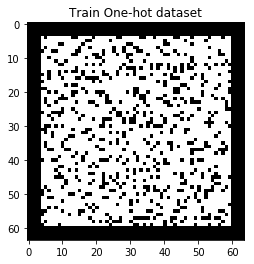

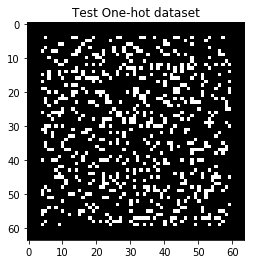

In [4]:
# Plot dataset

plt.imshow(np.sum(train_onehot, axis=0)[:, :, 0], cmap='gray')
plt.title('Train One-hot dataset')
plt.show()
plt.imshow(np.sum(test_onehot, axis=0)[:, :, 0], cmap='gray')
plt.title('Test One-hot dataset')
plt.show()

Training data set label #0, x coordinate: 


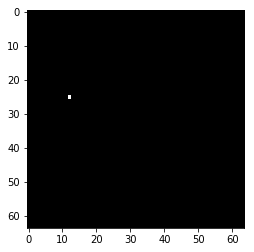

exit


In [5]:
for i in range(len(train_onehot)):
    plt.imshow(train_onehot[i, :, :, 0], cmap='gray')
    print("Training data set label #{}, x coordinate: ".format(i))
    plt.show()

    if input()== 'exit':
        break

# Coordconv Model

In [6]:
#model 
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Softmax, MaxPooling2D
from coord_conv import CoordConv

model = Sequential([
    CoordConv(x_dim = 64, y_dim = 64, with_r = False, filters = 8, 
              kernel_size = 1, padding='same', activation='relu'),
    Conv2D(filters = 8, kernel_size = 1, strides = 1, padding = "same", activation = 'relu'), 
    Conv2D(filters = 8, kernel_size = 1, strides = 1, padding = "same", activation = 'relu'), 
    Conv2D(filters = 8, kernel_size = 3, strides = 1, padding = "same", activation = 'relu'), 
    Conv2D(filters = 2, kernel_size = 3, strides = 1, padding = "same", activation = 'relu'), 
    MaxPooling2D(pool_size = 64, strides = 64, padding = 'valid'),
    #output shape(batch_size, 1, 1, 2)
])

model.build((None, 64,64, 1))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coord_conv (CoordConv)       multiple                  32        
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  72        
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  72        
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  584       
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  146       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
Total params: 906
Trainable params: 906
Non-trainable params: 0
__________________________________________________________

In [8]:
#model input coordinates

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer, 'mean_squared_error', metrics=['accuracy'])
model.fit(train_onehot,xy_coord_train, batch_size = 32, epochs = 20,
          verbose = 1, validation_data = (test_onehot, xy_coord_test))

Train on 2508 samples, validate on 628 samples
Epoch 1/20
2508/2508 [==============================] - 1s 592us/sample - loss: 369.7203 - accuracy: 0.5040 - val_loss: 257.0155 - val_accuracy: 0.5127
Epoch 2/20
2508/2508 [==============================] - 1s 240us/sample - loss: 269.3976 - accuracy: 0.4809 - val_loss: 264.4538 - val_accuracy: 0.4873
Epoch 3/20
2508/2508 [==============================] - 1s 209us/sample - loss: 267.9517 - accuracy: 0.5080 - val_loss: 257.0467 - val_accuracy: 0.4873
Epoch 4/20
2508/2508 [==============================] - 1s 238us/sample - loss: 274.7059 - accuracy: 0.5000 - val_loss: 258.7748 - val_accuracy: 0.4873
Epoch 5/20
2508/2508 [==============================] - 1s 223us/sample - loss: 266.7139 - accuracy: 0.5136 - val_loss: 264.8681 - val_accuracy: 0.5127
Epoch 6/20
2508/2508 [==============================] - 1s 232us/sample - loss: 268.3736 - accuracy: 0.4896 - val_loss: 264.2140 - val_accuracy: 0.4873
Epoch 7/20
2508/2508 [===================

In [16]:
test = np.squeeze(preds[0])
print(test.shape)

(2,)


In [22]:
preds[0,:,:,0]

array([[29.432579]], dtype=float32)

In [17]:
test

array([29.432579, 29.099714], dtype=float32)

True coordinates: [[[25. 31.]]]
Predicted coordinates: [[[25.32437  30.672096]]]
Error: 0.46123355627059937


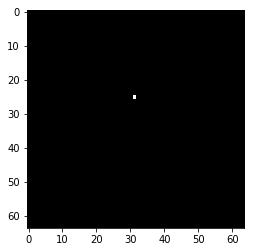


True coordinates: [[[31. 17.]]]
Predicted coordinates: [[[31.321613 16.694048]]]
Error: 0.4438939094543457


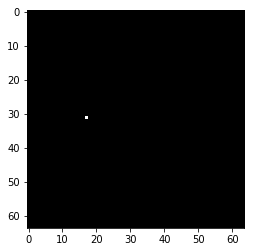

exit


In [9]:
#Visualize test set
preds = model.predict(test_onehot)

def error(true_coord, pred_coord, i):
    x_dif = true_coord[i,0,0,0] - pred_coord[i,0,0,0]
    y_dif = true_coord[i,0,0,1] - pred_coord[i,0,0,1]
    return np.sqrt(np.square(x_dif)+np.square(y_dif))

for i in range(len(xy_coord_test)):
    print('True coordinates: {}'.format(xy_coord_test[i]))
    print('Predicted coordinates: {}'.format(preds[i]))
    print('Error: {}' .format(error(xy_coord_test, preds, i)))
    plt.imshow(np.reshape(test_onehot[i], (64, 64)), cmap='gray')
    plt.show()
    
    if input() == 'exit':
        break

# Normal Covnet Model

In [10]:
covnet = Sequential([
    Conv2D(filters = 8, kernel_size = 1, strides = 1, padding = "same", activation = 'relu'), 
    Conv2D(filters = 8, kernel_size = 1, strides = 1, padding = "same", activation = 'relu'), 
    Conv2D(filters = 8, kernel_size = 1, strides = 1, padding = "same", activation = 'relu'), 
    Conv2D(filters = 8, kernel_size = 3, strides = 1, padding = "same", activation = 'relu'), 
    Conv2D(filters = 2, kernel_size = 3, strides = 1, padding = "same", activation = 'relu'), 
    MaxPooling2D(pool_size = 64, strides = 64, padding = 'valid'),
    #output shape(batch_size, 1, 1, 2)
])

covnet.build((None, 64,64, 1))

In [11]:
ptimizer = tf.keras.optimizers.Adam(lr=0.01)
covnet.compile(optimizer, 'mean_squared_error', metrics=['accuracy'])
covnet.fit(train_onehot,xy_coord_train, batch_size = 32, epochs = 20,
          verbose = 1, validation_data = (test_onehot, xy_coord_test))

Train on 2508 samples, validate on 628 samples
Epoch 1/20
2508/2508 [==============================] - 1s 306us/sample - loss: 367.0234 - accuracy: 0.5000 - val_loss: 269.3990 - val_accuracy: 0.4873
Epoch 2/20
2508/2508 [==============================] - 0s 193us/sample - loss: 266.4491 - accuracy: 0.4912 - val_loss: 256.1031 - val_accuracy: 0.5127
Epoch 3/20
2508/2508 [==============================] - 0s 199us/sample - loss: 266.2829 - accuracy: 0.4976 - val_loss: 257.5842 - val_accuracy: 0.5127
Epoch 4/20
2508/2508 [==============================] - 0s 173us/sample - loss: 267.0848 - accuracy: 0.4936 - val_loss: 255.5816 - val_accuracy: 0.5127
Epoch 5/20
2508/2508 [==============================] - 1s 219us/sample - loss: 264.2374 - accuracy: 0.5183 - val_loss: 261.7780 - val_accuracy: 0.4873
Epoch 6/20
2508/2508 [==============================] - 1s 220us/sample - loss: 265.1623 - accuracy: 0.4944 - val_loss: 258.0636 - val_accuracy: 0.5127
Epoch 7/20
2508/2508 [===================

True coordinates: [[[25. 31.]]]
Predicted coordinates: [[[29.432579 29.099714]]]
Error: 4.822741985321045


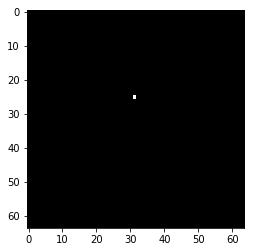

exit


In [12]:
preds = covnet.predict(test_onehot)

def error(true_coord, pred_coord, i):
    x_dif = true_coord[i,0,0,0] - pred_coord[i,0,0,0]
    y_dif = true_coord[i,0,0,1] - pred_coord[i,0,0,1]
    return np.sqrt(np.square(x_dif)+np.square(y_dif))

for i in range(len(xy_coord_test)):
    print('True coordinates: {}'.format(xy_coord_test[i]))
    print('Predicted coordinates: {}'.format(preds[i]))
    print('Error: {}' .format(error(xy_coord_test, preds, i)))
    plt.imshow(np.reshape(test_onehot[i], (64, 64)), cmap='gray')
    plt.show()
    
    if input() == 'exit':
        break